## Introduction
Here we train our tumor segmentation network. <br />

## Imports:

* Pathlib for easy path handling
* torch for tensor handling
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* imgaug for Data Augmentation
* numpy for file loading and array ops
* matplotlib for visualizing some images
* tqdm for progress par when validating the model
* celluloid for easy video generation
* Our dataset and model

In [1]:
import matplotlib
# Force a Jupyter inline-capable backend if it's not already
if 'inline' not in matplotlib.get_backend().lower():
    try:
        matplotlib.use('module://matplotlib_inline.backend_inline')
    except Exception as e:
        print("Backend set error:", e)

In [2]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from celluloid import Camera

In [3]:
from pathlib import Path
import importlib.util, os

# put the folder with dataset.py/model.py on sys.path
import sys
sys.path.insert(0, r"E:/DoNotTouch/projects/LANSCLC/CIS_5810")

import dataset   # loads dataset.py
import model     # loads model.py

LungDataset = dataset.LungDataset
UNet        = model.UNet

print(LungDataset.__module__)  # should print "dataset"

dataset


## Dataset Creation
Here we create the train and validation dataset. <br />
Additionally we define our data augmentation pipeline.
Subsequently the two dataloaders are created

In [4]:
seq = iaa.Sequential([
    iaa.Affine(translate_percent=(0.15),
               scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)#
               ),  # rotate up to 45 degrees
    iaa.ElasticTransformation()  # Elastic Transformations
                ])

In [5]:
import random, numpy as np, torch, pytorch_lightning as pl

SEED = 1337
pl.seed_everything(SEED, workers=True)

# For strict reproducibility (slower but stable):
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create the dataset objects
BASE = Path("E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split")
train_path = BASE / "Preprocessed_for_2D_Unet/train"
val_path = BASE / "Preprocessed_for_2D_Unet/val"
test_path = BASE / "Preprocessed_for_2D_Unet/test"

train_dataset = LungDataset(train_path, seq)
val_dataset = LungDataset(val_path, None)
test_dataset = LungDataset(test_path, None)

print(f"There are {len(train_dataset)} train images, {len(val_dataset)} val images and {len(test_dataset)} test images")

Seed set to 1337


There are 7876 train images, 4236 val images and 5222 test images


## Oversampling to tackle strong class imbalance
Lung tumors are often very small, thus we need to make sure that our model does not learn a trivial solution which simply outputs 0 for all voxels.<br />
In this notebook we use oversampling to sample slices which contain a tumor more often.

To do so we can use the WeightedRandomSampler provided by pytorch which needs a weight for each sample in the dataset.
Typically we have one weight for each class, which means that we need to calculate two weights, one for slices without tumors and one for slices with a tumor and create list that assigns each sample from the dataset the corresponding weight

To do so, we at first need to create a list containing only the class labels:

In [6]:
from tqdm import tqdm
import numpy as np
from contextlib import contextmanager

@contextmanager
def disable_aug(ds):
    prev = getattr(ds, "augment_params", None)
    try:
        ds.augment_params = None
        yield ds
    finally:
        ds.augment_params = prev

def has_tumor(mask, thr=0.5):
    a = np.asarray(mask)
    a = np.squeeze(a)
    if a.ndim == 3:               # collapse channel dim if present
        a = (a > thr).any(axis=0)
    return int((a > thr).any())

with disable_aug(train_dataset):
    target_list = []
    for i in tqdm(range(len(train_dataset))):
        _, label = train_dataset[i]     # now no imgaug/warpAffine is triggered
        target_list.append(has_tumor(label))

pos = sum(target_list)
print(f"positives: {pos}/{len(target_list)} ({100*pos/len(target_list):.1f}%)")

100%|█████████████████████████████████████████████████████████████████████████████| 7876/7876 [00:10<00:00, 717.99it/s]

positives: 1949/7876 (24.7%)


Then we can calculate the weight for each class: To do so, we can simply compute the fraction between the classes and then create the weight list

In [7]:
# !pip uninstall -y opencv-python opencv-contrib-python opencv-python-headless thinc
# !pip install -U --force-reinstall --no-cache-dir numpy==1.26.4 scipy==1.11.4
# !pip install -U imgaug==0.4.0
# !pip install -U "opencv-python==4.8.1.78" "opencv-contrib-python==4.8.1.78" "opencv-python-headless==4.8.1.78"
# # (Only if you truly need thinc/spaCy here)
# # pip install "thinc<8.3"


In [8]:
uniques = np.unique(target_list, return_counts=True)
uniques

(array([0, 1]), array([5927, 1949], dtype=int64))

In [9]:
fraction = uniques[1][0] / uniques[1][1]
fraction

3.0410466906105693

Subsequently we assign the weight 1 to each slice without a tumor and ~9 to each slice with a tumor

In [10]:
weight_list = []
for target in target_list:
    if target == 0:
        weight_list.append(1)
    else:
        weight_list.append(fraction)

In [11]:
weight_list[:100]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 1,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 1,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 3.0410466906105693,
 1,
 3.0410466906105693,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

Finally we create the sampler which we can pass to the DataLoader. We only use a sampler for the train loader. We dont't want to change the validation data to get a real validation.

In [12]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_list, len(weight_list))

In [13]:
batch_size = 8
num_workers = 23

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, sampler=sampler, pin_memory=True, persistent_workers=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=True, persistent_workers=True)

We can verify that our sampler works by taking a batch from the train loader and count how many labels are larger than zero

In [14]:
verify_sampler = next(iter(train_loader))

In [15]:
(verify_sampler[1][:,0]).sum([1, 2]) > 0  # ~ half the batch size

tensor([False, False,  True,  True, False, False, False,  True])

## Loss

We use the Binary Cross Entropy

## Full Segmentation Model

We now combine everything into the full pytorch lightning model

In [16]:
# Imports – run this first in the notebook
import torch
import torch.nn as nn                    # <-- fixes NameError: nn
import numpy as np
import matplotlib.pyplot as plt

import pytorch_lightning as pl           # use ONE namespace
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from IPython.display import display

class LiveEpochCurves(pl.Callback):
    def __init__(self, title="2D U-Net — Loss & Dice (per epoch)"):
        super().__init__()
        self.hist = {k: [] for k in ("train_loss","val_loss","train_dice","val_dice")}
        self.epochs = []
        self._h_loss = None
        self._h_dice = None
        self._pend_train = {}
        self.title = title

    @staticmethod
    def _f(v):
        try:
            return float(v.detach().cpu()) if hasattr(v, "detach") else float(v)
        except Exception:
            return float('nan')

    @staticmethod
    def _cands(split, kind):
        b = f"{split}_{kind}"
        # include many Lightning aliases + our manual epoch means
        extra = []
        if split == "train":
            extra += [f"{b}_epoch", f"{b}_epoch_mean",
                      "train_loss_epoch_mean" if kind=="loss" else "train_dice_epoch_mean"]
        return [b, f"{b}_epoch", f"{b}/dataloader_idx_0",
                f"{b}_epoch/dataloader_idx_0", f"{split}/{kind}", f"{kind}/{split}"] + extra

    def _get(self, split, kind, trainer):
        pools = [trainer.callback_metrics, getattr(trainer, "logged_metrics", {})]
        for pool in pools:
            for n in self._cands(split, kind):
                if n in pool:
                    return self._f(pool[n])
        return float('nan')

    def on_train_epoch_end(self, trainer, pl_module):
        # stash train metrics after train epoch
        self._pend_train = {
            "train_loss": self._get("train","loss", trainer),
            "train_dice": self._get("train","dice", trainer),
        }
        if not getattr(trainer, "val_dataloaders", None):
            self._append_and_plot(trainer.current_epoch, {
                **self._pend_train, "val_loss": float('nan'), "val_dice": float('nan')
            })
            self._pend_train = {}

    def on_validation_epoch_end(self, trainer, pl_module):
        # prefer stashed values; if NaN, fall back to module accumulators
        tl = self._pend_train.get("train_loss", self._get("train","loss", trainer))
        td = self._pend_train.get("train_dice", self._get("train","dice", trainer))

        if (not np.isfinite(tl)) and hasattr(pl_module, "_train_count") and pl_module._train_count > 0:
            tl = float(pl_module._train_loss_sum) / float(pl_module._train_count)
        if (not np.isfinite(td)) and hasattr(pl_module, "_train_count") and pl_module._train_count > 0:
            td = float(pl_module._train_dice_sum) / float(pl_module._train_count)

        row = {
            "train_loss": tl,
            "val_loss":   self._get("val","loss", trainer),
            "train_dice": td,
            "val_dice":   self._get("val","dice", trainer),
        }
        self._append_and_plot(trainer.current_epoch, row)
        self._pend_train = {}

    def _append_and_plot(self, epoch_idx, row):
        for k, v in row.items():
            self.hist[k].append(v)
        self.epochs.append(float(epoch_idx))
        xs = np.asarray(self.epochs, float)

        # ----- LOSS -----
        fig1, ax1 = plt.subplots(figsize=(6,4))
        y = np.asarray(self.hist["train_loss"], float); m = np.isfinite(y)
        if m.any(): ax1.plot(xs[:len(y)][m], y[m], label="train_loss")
        y = np.asarray(self.hist["val_loss"], float); m = np.isfinite(y)
        if m.any(): ax1.plot(xs[:len(y)][m], y[m], label="val_loss", marker="o")
        ax1.set_title("loss"); ax1.set_xlabel("epoch"); ax1.set_ylabel("loss")
        ax1.set_xlim(left=0)  # start at epoch 0
        ax1.grid(True); ax1.legend(loc="best"); plt.tight_layout()
        self._h_loss = (self._h_loss or display(fig1, display_id=True)); self._h_loss.update(fig1); plt.close(fig1)

        # ----- DICE -----
        fig2, ax2 = plt.subplots(figsize=(6,4))
        y = np.asarray(self.hist["train_dice"], float); m = np.isfinite(y)
        if m.any(): ax2.plot(xs[:len(y)][m], y[m], label="train_dice")
        y = np.asarray(self.hist["val_dice"], float); m = np.isfinite(y)
        if m.any(): ax2.plot(xs[:len(y)][m], y[m], label="val_dice", marker="o")
        ax2.set_title("dice"); ax2.set_xlabel("epoch"); ax2.set_ylabel("dice")
        ax2.set_xlim(left=0)  # start at epoch 0
        ax2.grid(True); ax2.legend(loc="best"); plt.tight_layout()
        self._h_dice = (self._h_dice or display(fig2, display_id=True)); self._h_dice.update(fig2); plt.close(fig2)



import torch

def nan_safe(x: torch.Tensor, fill: float = 0.0) -> torch.Tensor:
    # Replace NaN/±Inf with a finite fill
    return torch.nan_to_num(x, nan=fill, posinf=fill, neginf=fill)

@torch.no_grad()
def batch_dice_from_logits(
    logits: torch.Tensor, target: torch.Tensor,
    threshold: float = 0.5, eps: float = 1e-6,
    ignore_empty: bool = True, empty_target_score: float = 1.0
):
    probs = torch.sigmoid(logits)
    probs = torch.where(torch.isfinite(probs), probs, torch.zeros_like(probs))

    pred  = (probs > threshold).float()
    target = torch.where(torch.isfinite(target), target, torch.zeros_like(target))

    inter    = (pred * target).flatten(1).sum(1)
    pred_sum = pred.flatten(1).sum(1)
    gt_sum   = target.flatten(1).sum(1)

    dice = (2 * inter + eps) / (pred_sum + gt_sum + eps)

    if ignore_empty:
        no_obj = (gt_sum == 0)
        if empty_target_score is not None:
            empty_ok = (pred_sum == 0).float() * empty_target_score
            dice = torch.where(no_obj, empty_ok, dice)
        else:
            keep = ~no_obj
            dice = dice[keep] if keep.any() else torch.tensor(float("nan"), device=logits.device)

    return dice.mean()



import pytorch_lightning as pl
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class TumorSegmentation(pl.LightningModule):
    def __init__(self, lr: float = 1e-4):
        super().__init__()
        self.model = UNet().float()
        self.lr = lr
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x): return self.model(x)

    def on_train_epoch_start(self):
        self._train_loss_sum = 0.0
        self._train_dice_sum = 0.0
        self._train_count    = 0

    def training_step(self, batch, batch_idx):
        ct, mask = batch
        ct   = torch.nan_to_num(ct.float())
        mask = torch.nan_to_num(mask.float()).clamp_(0, 1)

        logits = self(ct)
        logits = torch.where(torch.isfinite(logits), logits, torch.zeros_like(logits))

        loss = self.loss_fn(logits, mask)
        dice = batch_dice_from_logits(logits, mask, ignore_empty=True, empty_target_score=1.0)

        # accumulate for epoch means (robust against Lightning aliasing)
        bs = ct.size(0)
        self._train_loss_sum += float(loss.detach()) * bs
        self._train_dice_sum += float(dice.detach()) * bs
        self._train_count    += bs

        # still log per-epoch via Lightning (keeps TB & ckpts happy)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=bs)
        self.log("train_dice", dice, on_step=False, on_epoch=True, prog_bar=True, batch_size=bs)
        return loss

    def on_train_epoch_end(self):
        if self._train_count > 0:
            tl = self._train_loss_sum / self._train_count
            td = self._train_dice_sum / self._train_count
            # emit explicit epoch means so the live callback always has finite values
            self.log("train_loss_epoch_mean", tl, prog_bar=False, on_epoch=True, logger=True)
            self.log("train_dice_epoch_mean", td, prog_bar=False, on_epoch=True, logger=True)

    def validation_step(self, batch, batch_idx):
        ct, mask = batch
        ct   = torch.nan_to_num(ct.float())
        mask = torch.nan_to_num(mask.float()).clamp_(0, 1)

        logits = self(ct)
        logits = torch.where(torch.isfinite(logits), logits, torch.zeros_like(logits))

        val_loss = self.loss_fn(logits, mask)
        val_dice = batch_dice_from_logits(logits, mask, ignore_empty=True, empty_target_score=1.0)

        bs = ct.size(0)
        self.log("val_loss", val_loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=bs)
        self.log("val_dice", val_dice, on_step=False, on_epoch=True, prog_bar=True, batch_size=bs)
        return val_loss


    def log_images(self, ct, logits, mask, split_name: str):
        probs = torch.sigmoid(logits)
        pr = (probs > 0.5)

        img = ct[0, 0].detach().cpu().numpy()
        gt  = mask[0, 0].detach().cpu().numpy()
        pb  = pr[0, 0].detach().cpu().numpy()

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(img, cmap="bone"); ax[0].imshow(np.ma.masked_where(gt == 0, gt), alpha=0.6)
        ax[0].set_title("Ground Truth"); ax[0].axis("off")
        ax[1].imshow(img, cmap="bone"); ax[1].imshow(np.ma.masked_where(pb == 0, pb), alpha=0.6, cmap="autumn")
        ax[1].set_title("Prediction"); ax[1].axis("off")
        self.logger.experiment.add_figure(f"{split_name} Prediction vs Label", fig, self.global_step)
        plt.close(fig)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [17]:
# Instanciate the model
model = TumorSegmentation()

In [18]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

progress_bar = pl.callbacks.TQDMProgressBar(refresh_rate=1)  # ensure val bar updates
live_cb = LiveEpochCurves()

ckpt_loss = ModelCheckpoint(dirpath="ckpts/loss", filename="loss-{epoch:03d}-{val_loss:.4f}",
                            monitor="val_loss", mode="min", save_top_k=5, save_last=True)
ckpt_dice = ModelCheckpoint(dirpath="ckpts/dice", filename="dice-{epoch:03d}-{val_dice:.4f}",
                            monitor="val_dice", mode="max", save_top_k=3)


In [19]:
trainer = pl.Trainer(
    accelerator="gpu", devices=1,
    logger=TensorBoardLogger(save_dir="./logs"),
    enable_progress_bar=True,
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    num_sanity_val_steps=0,          # avoids pre-epoch confusion
    callbacks=[progress_bar, live_cb, ckpt_loss, ckpt_dice],
    max_epochs=100,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


C:\ProgramData\Anaconda3\envs\py38\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory E:\DoNotTouch\projects\LANSCLC\CIS_5810\2D U-Net\ckpts\loss exists and is not empty.
C:\ProgramData\Anaconda3\envs\py38\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory E:\DoNotTouch\projects\LANSCLC\CIS_5810\2D U-Net\ckpts\dice exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | UNet              | 7.8 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

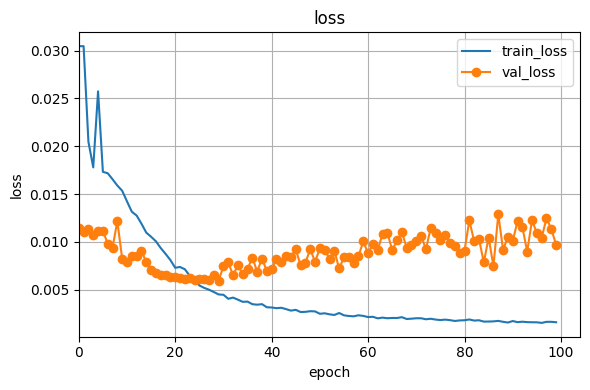

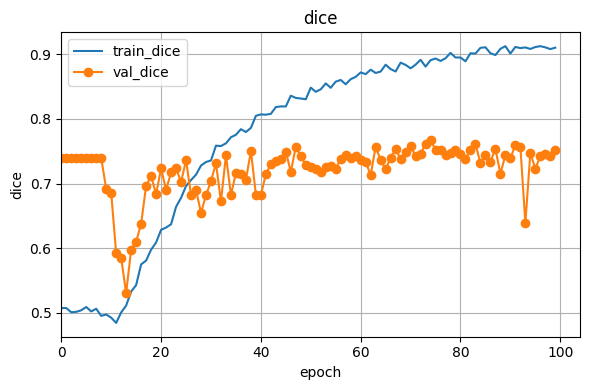

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


In [20]:
trainer.fit(model, train_loader, val_loader)

## Evaluation:
Evaluate the results

In [23]:
class DiceScore(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):

        #flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)

        counter = (pred * mask).sum()  # Counter
        denum = pred.sum() + mask.sum()  # denominator
        dice = (2*counter)/denum

        return dice

In [25]:
from pathlib import Path
import lightning.pytorch as pl  # or `import pytorch_lightning as pl` depending on your import

def resolve_ckpt_path(ckpt_cb: pl.callbacks.ModelCheckpoint) -> Path:
    # 1) Best model (preferred)
    p = Path(getattr(ckpt_cb, "best_model_path", "") or "")
    if p.is_file():
        return p
    # 2) "Last" model if available
    p = Path(getattr(ckpt_cb, "last_model_path", "") or "")
    if p.is_file():
        return p
    # 3) Newest .ckpt in the callback's dir
    d = Path(ckpt_cb.dirpath)
    cands = sorted(d.glob("*.ckpt"), key=lambda x: x.stat().st_mtime, reverse=True)
    if cands:
        return cands[0]
    raise FileNotFoundError(f"No checkpoints found in {d}")

# --- choose which checkpoint callback to use ---
checkpoint_callback = ckpt_dice   # or `ckpt_loss` if you prefer the loss-monitored one

# --- resolve and load ---
ckpt_path = resolve_ckpt_path(checkpoint_callback)
print(f"Loading checkpoint: {ckpt_path}")

model = TumorSegmentation.load_from_checkpoint(
    ckpt_path,
    map_location="cuda" if torch.cuda.is_available() else "cpu",
    # strict=True  # set False if your module signature changed
)

Loading checkpoint: E:\DoNotTouch\projects\LANSCLC\CIS_5810\2D U-Net\ckpts\dice\dice-epoch=074-val_dice=0.7673.ckpt


In [42]:
import torch
from tqdm import tqdm

# device + eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

probs, labels = [], []

with torch.no_grad():
    for slc, lbl in tqdm(val_dataset):
        x = to_batch_1ch(slc).to(device, non_blocking=True)   # [1,1,H,W]
        logits = model(x)                                     # [1,C,H,W]
        if logits.shape[1] == 1:                              # 1-channel head
            p = torch.sigmoid(logits[0, 0]).cpu()             # [H,W]
        else:                                                 # 2-channel head (bg,tumor)
            p = torch.softmax(logits, dim=1)[0, 1].cpu()      # tumor prob [H,W]
        probs.append(p)
        y = torch.as_tensor(lbl).float()
        if y.ndim == 3 and y.shape[0] == 1:                   # [1,H,W] -> [H,W]
            y = y[0]
        elif y.ndim == 3 and y.shape[-1] == 1:                # [H,W,1] -> [H,W]
            y = y[..., 0]
        labels.append(y.cpu())

100%|█████████████████████████████████████████████████████████████████████████████| 4236/4236 [00:34<00:00, 121.78it/s]


Compute overall Dice Score on the Validation Set

In [43]:
# stack to [N,H,W]
preds_t  = torch.stack(probs)          # probabilities in [0,1]
labels_t = torch.stack(labels).float()

# binarize
pred_bin = preds_t > 0.5
gt_bin   = labels_t > 0.5

def dice_batch(pred: torch.Tensor, tgt: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    pred = pred.bool(); tgt = tgt.bool()
    inter = (pred & tgt).sum(dim=(1, 2))
    denom = pred.sum(dim=(1, 2)) + tgt.sum(dim=(1, 2))
    return ((2 * inter + eps) / (denom + eps)).mean()

dice_score = dice_batch(pred_bin, gt_bin).item()
print(f"Val Dice (slice-wise): {dice_score:.4f}")

Val Dice (slice-wise): 0.7673


In [53]:
import torch
from tqdm import tqdm

# device + eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

probs, labels = [], []

with torch.no_grad():
    for slc, lbl in tqdm(test_dataset):
        x = to_batch_1ch(slc).to(device, non_blocking=True)   # [1,1,H,W]
        logits = model(x)                                     # [1,C,H,W]
        if logits.shape[1] == 1:                              # 1-channel head
            p = torch.sigmoid(logits[0, 0]).cpu()             # [H,W]
        else:                                                 # 2-channel head (bg,tumor)
            p = torch.softmax(logits, dim=1)[0, 1].cpu()      # tumor prob [H,W]
        probs.append(p)
        y = torch.as_tensor(lbl).float()
        if y.ndim == 3 and y.shape[0] == 1:                   # [1,H,W] -> [H,W]
            y = y[0]
        elif y.ndim == 3 and y.shape[-1] == 1:                # [H,W,1] -> [H,W]
            y = y[..., 0]
        labels.append(y.cpu())

100%|█████████████████████████████████████████████████████████████████████████████| 5222/5222 [00:42<00:00, 121.59it/s]


Compute overall Dice Score on the Test Set

In [54]:
# stack to [N,H,W]
preds_t  = torch.stack(probs)          # probabilities in [0,1]
labels_t = torch.stack(labels).float()

# binarize
pred_bin = preds_t > 0.5
gt_bin   = labels_t > 0.5

def dice_batch(pred: torch.Tensor, tgt: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    pred = pred.bool(); tgt = tgt.bool()
    inter = (pred & tgt).sum(dim=(1, 2))
    denom = pred.sum(dim=(1, 2)) + tgt.sum(dim=(1, 2))
    return ((2 * inter + eps) / (denom + eps)).mean()

dice_score = dice_batch(pred_bin, gt_bin).item()
print(f"Test Dice (slice-wise): {dice_score:.4f}")

Test Dice (slice-wise): 0.8281


In [45]:
from collections import defaultdict
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import torch

# ---------- Dice ----------
def _dice_coef(pred_bin: np.ndarray, gt_bin: np.ndarray, eps: float = 1e-7) -> float:
    pred_bin = pred_bin.astype(bool)
    gt_bin   = gt_bin.astype(bool)
    inter = np.logical_and(pred_bin, gt_bin).sum()
    denom = pred_bin.sum() + gt_bin.sum()
    if denom == 0:
        return 1.0
    return float((2.0 * inter + eps) / (denom + eps))

# ---------- dataset path helpers ----------
def _get_paths_attr(ds):
    """
    Returns a list-like of slice paths aligned with ds[i].
    Tries common attribute names.
    """
    for name in ("all_files", "files", "paths", "slices"):
        if hasattr(ds, name):
            return getattr(ds, name)
    raise AttributeError(
        "Dataset must expose a list of slice paths via "
        "`all_files`, `files`, `paths`, or `slices`."
    )

def _pid_from_slice_path(p: Path) -> str:
    """
    Extract a patient ID from a path like .../<patient>/data/<slice>.npy or .../<patient>/<slice>.npy
    Adjust if your structure differs.
    """
    # try .../<patient>/data/<slice>
    if p.parent.name.lower() == "data" and p.parent.parent.name:
        return p.parent.parent.name
    # fallback: immediate parent dir
    return p.parent.name

def _slice_idx_from_path(p: Path) -> int:
    """
    Assumes file stem is an integer slice index, e.g., '0123.npy' -> 123.
    Adjust if needed.
    """
    try:
        return int(Path(p).stem)
    except Exception:
        # fallback: order as 0..N-1 if not parseable
        return 0

# ---------- tensor/array sanitizers ----------
def _ensure_img_tensor(x) -> torch.Tensor:
    """
    Returns float32 torch tensor of shape (1, H, W) on CPU.
    Accepts numpy or torch; shapes (H,W), (1,H,W), (H,W,1).
    """
    if torch.is_tensor(x):
        t = x.detach().cpu().float()
    else:
        t = torch.as_tensor(x, dtype=torch.float32)

    if t.ndim == 2:
        pass  # (H,W)
    elif t.ndim == 3:
        # accept (1,H,W) or (H,W,1)
        if t.shape[0] == 1:
            t = t[0]            # -> (H,W)
        elif t.shape[-1] == 1:
            t = t[..., 0]       # -> (H,W)
        else:
            raise ValueError(f"Expected single-channel image; got shape {tuple(t.shape)}")
    else:
        raise ValueError(f"Expected 2D image or single-channel 3D; got ndim={t.ndim}")

    return t.unsqueeze(0)        # -> (1,H,W)

def _ensure_mask_np(y) -> np.ndarray:
    """
    Returns float32 numpy array of shape (H, W).
    Accepts numpy or torch; shapes (H,W), (1,H,W), (H,W,1).
    """
    if torch.is_tensor(y):
        a = y.detach().cpu().numpy()
    else:
        a = np.asarray(y)

    if a.ndim == 2:
        pass
    elif a.ndim == 3:
        if a.shape[0] == 1:
            a = a[0]
        elif a.shape[-1] == 1:
            a = a[..., 0]
        else:
            raise ValueError(f"Expected single-channel mask; got shape {a.shape}")
    else:
        raise ValueError(f"Mask must be 2D or single-channel 3D; got ndim={a.ndim}")

    return a.astype(np.float32, copy=False)

# ---------- main evaluation ----------
@torch.no_grad()
def eval_by_patient(
    dataset,
    model: torch.nn.Module,
    threshold: float = 0.5,
    device: torch.device = None,
    verbose: bool = True,
) -> Tuple[Dict[str, float], Dict[str, np.ndarray], Dict[str, np.ndarray]]:
    """
    Groups 2D slices per patient (from dataset paths), runs the model slice-wise,
    reconstructs (D,H,W) volumes per patient, and computes per-patient Dice.
    Works whether dataset returns numpy arrays or torch tensors.
    """
    # resolve device & place model
    if device is None:
        device = next(model.parameters()).device
    model = model.to(device).eval()

    # paths aligned with dataset indexing
    paths = _get_paths_attr(dataset)

    # pid -> list of (slice_idx, prob2d, gt2d)
    by_patient = defaultdict(list)

    for idx in range(len(dataset)):
        x, y = dataset[idx]          # image slice, mask slice
        img_t = _ensure_img_tensor(x)            # (1,H,W), CPU float32
        gt2d  = _ensure_mask_np(y)               # (H,W),  CPU float32

        p = Path(str(paths[idx]))
        pid  = _pid_from_slice_path(p)
        sidx = _slice_idx_from_path(p)

        # (N=1,C=1,H,W) expected by 2D model
        logits = model(img_t.unsqueeze(0).to(device))  # -> (1,C,H,W)
        C = logits.shape[1]
        if C == 1:
            prob2d = torch.sigmoid(logits)[0, 0].cpu().numpy()
        else:
            prob2d = torch.softmax(logits, dim=1)[0, 1].cpu().numpy()

        by_patient[pid].append((sidx, prob2d.astype(np.float32, copy=False), gt2d))

    patient_dice: Dict[str, float] = {}
    patient_pred_vols: Dict[str, np.ndarray] = {}
    patient_gt_vols: Dict[str, np.ndarray] = {}

    for pid, triples in by_patient.items():
        # order slices by index and stack to (D,H,W)
        triples.sort(key=lambda t: t[0])
        pred_vol = np.stack([t[1] for t in triples], axis=0)
        gt_vol   = np.stack([t[2] for t in triples], axis=0)

        pred_bin = (pred_vol >= float(threshold))
        gt_bin   = (gt_vol  >  0.0)

        patient_pred_vols[pid] = pred_vol
        patient_gt_vols[pid]   = gt_vol
        patient_dice[pid]      = _dice_coef(pred_bin, gt_bin)

    if verbose and patient_dice:
        vals = np.array(list(patient_dice.values()), dtype=np.float32)
        print(f"Patients: {len(vals)} | mean Dice: {vals.mean():.4f} | median: {np.median(vals):.4f} "
              f"| std: {vals.std(ddof=0):.4f} | min: {vals.min():.4f} | max: {vals.max():.4f}")

    return patient_dice, patient_pred_vols, patient_gt_vols

In [46]:
val_dice, val_pred_vols, val_gt_vols = eval_by_patient(val_dataset, model, threshold=0.5)
val_dice

Patients: 40 | mean Dice: 0.3258 | median: 0.2725 | std: 0.2937 | min: 0.0000 | max: 0.8901


{'100': 0.4238085060972023,
 '101': 0.5702286144476001,
 '102': 0.4404979040688602,
 '103': 0.28645724984645154,
 '104': 2.475860361414314e-11,
 '105': 0.003574087870412702,
 '106': 0.8733974358983582,
 '107': 0.3756134622900355,
 '108': 0.00029686805699425756,
 '109': 0.4929492949313946,
 '70': 0.27468448404274637,
 '71': 0.6988542035225789,
 '72': 0.2600860785999755,
 '73': 0.060040270922020494,
 '74': 0.7586391642132455,
 '75': 0.2703118983462503,
 '76': 0.09584335281525518,
 '77': 0.3022565320716875,
 '78': 0.7951739392728929,
 '79': 0.15296610171286087,
 '80': 0.013154288855274006,
 '81': 0.2446439502219481,
 '82': 0.4009249661159323,
 '83': 0.25634727973937926,
 '84': 2.068252326741091e-11,
 '85': 0.06838780555432307,
 '86': 0.5941596016697775,
 '87': 0.7920050609540719,
 '88': 0.008927038643623571,
 '89': 0.504146624649593,
 '90': 0.8901081882344961,
 '91': 0.057400722038675085,
 '92': 0.8633262001862828,
 '93': 0.015017520448731706,
 '94': 3.5280835450058983e-12,
 '95': 0.73095

In [47]:
test_dice, test_pred_vols, test_gt_vols = eval_by_patient(test_dataset, model, threshold=0.5)
test_dice

Patients: 40 | mean Dice: 0.4828 | median: 0.5463 | std: 0.3067 | min: 0.0000 | max: 0.9263


{'110': 0.29538162372729515,
 '111': 0.7859189963781652,
 '112': 0.714817399398525,
 '113': 0.8174786879703185,
 '114': 0.028876936870825723,
 '115': 0.6338153598251397,
 '116': 0.002053809837706843,
 '117': 0.7408946467887938,
 '118': 0.46865171511869536,
 '119': 0.1944925100133621,
 '120': 0.7666724406741151,
 '121': 0.4029773596670838,
 '122': 0.7358055592157298,
 '123': 0.00034299435773721496,
 '124': 0.40475467112484903,
 '125': 0.00023121388439039056,
 '126': 8.6192035855144e-12,
 '127': 0.8028815594335554,
 '128': 0.9263044647661834,
 '129': 0.5721595906326684,
 '130': 0.35490854796686283,
 '131': 0.7376344086037179,
 '132': 0.9157348766860859,
 '133': 0.7021015382414811,
 '134': 0.23850267380493576,
 '135': 0.9062912915559044,
 '136': 4.183925358754094e-12,
 '137': 0.7592439064841683,
 '138': 1.5299877600745104e-11,
 '139': 0.06971786835022296,
 '140': 0.7581550886506521,
 '141': 0.4475969890035939,
 '142': 0.20637576306033742,
 '143': 0.6487706974454495,
 '144': 0.858171346293

## Visualization

In [48]:
THRESHOLD = 0.5

In [49]:
import nibabel as nib
import cv2

In [50]:
BASE = Path("E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split")

subject = Path(BASE / "test" / "image" / "Lung_045_0000.nii.gz")
ct = nib.load(subject).get_fdata() / 3071  # standardize
ct = ct[:,:,30:]  # crop

In [51]:
segmentation = []
label = []
scan = []

for i in range(ct.shape[-1]):
    slice = ct[:,:,i]
    slice = cv2.resize(slice, (256, 256))
    slice = torch.tensor(slice)
    scan.append(slice)
    slice = slice.unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        pred = model(slice)[0][0].cpu()
    pred = pred > THRESHOLD
    segmentation.append(pred)
    label.append(segmentation)

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
import torch

def reorient_2d(a):
    # flip vertically, then rotate -90° (clockwise)
    return np.rot90(np.flipud(a), k=3)

def to_slice_list(x):
    """
    Return a list of 2D numpy arrays (same shape).
    Handles: torch.Tensor, list/tuple of slices, or a 3D volume (D,H,W) / (H,W,D).
    """
    # torch -> numpy
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()

    # squeeze singleton axes (e.g., [1, D, H, W] -> [D, H, W])
    arr = np.array(x, dtype=object)  # allow ragged temporarily
    try:
        arr = np.squeeze(np.asarray(x))
    except Exception:
        # if x is a ragged list, skip to list-branch below
        arr = None

    slices = None
    if isinstance(x, (list, tuple)):
        # list/tuple of slices
        slices = [np.asarray(s) for s in x]
    elif isinstance(arr, np.ndarray):
        if arr.ndim == 2:
            slices = [arr]
        elif arr.ndim == 3:
            # decide which axis is depth (use the one with the smallest size heuristically)
            # then move it to front so we have (D, H, W)
            d_axis = int(np.argmin(arr.shape))
            vol = np.moveaxis(arr, d_axis, 0)  # (D,H,W)
            slices = [vol[i] for i in range(vol.shape[0])]
        else:
            raise ValueError(f"Expected 2D/3D input or list of 2D slices; got array with ndim={arr.ndim}")
    else:
        raise ValueError("Unsupported input type for scan/segmentation.")

    # verify uniform shapes
    H, W = np.asarray(slices[0]).shape
    for i, s in enumerate(slices):
        if np.asarray(s).ndim != 2 or np.asarray(s).shape != (H, W):
            raise ValueError(f"Slice {i} has shape {np.asarray(s).shape}, "
                             f"but expected {(H, W)}. Resize/crop first so all slices match.")

    # ensure base float arrays
    return [np.asarray(s, dtype=np.float32, order="C") for s in slices]

# -------- build consistent slice lists --------
scan_slices = to_slice_list(scan)
seg_slices  = to_slice_list(segmentation)

# optional: ensure seg is binary/integer for masking
seg_slices  = [(s > 0).astype(np.uint8) for s in seg_slices]

N = min(len(scan_slices), len(seg_slices))

# reorient
scan_r = [reorient_2d(s) for s in scan_slices[:N]]
seg_r  = [reorient_2d(s) for s in seg_slices[:N]]

# -------- animate --------
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(scan_r[0], cmap="bone", interpolation="nearest")
ov = ax.imshow(np.ma.masked_where(seg_r[0]==0, seg_r[0]),
               cmap="autumn", alpha=0.5, interpolation="nearest")
ax.axis("off")

def update(i):
    im.set_data(scan_r[i])
    ov.set_data(np.ma.masked_where(seg_r[i]==0, seg_r[i]))
    return im, ov

anim = animation.FuncAnimation(fig, update, frames=range(0, N, 2), interval=80, blit=False)
display(HTML(anim.to_jshtml()))
plt.close(fig)

C:\Users\leesangh\AppData\Local\Temp\ipykernel_7992\785476086.py:21: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(x, dtype=object)  # allow ragged temporarily
C:\Users\leesangh\AppData\Local\Temp\ipykernel_7992\785476086.py:23: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either 